# 决策树与XGBoost详解

## 📚 算法介绍

### 决策树 (Decision Tree)
决策树是一种基于树结构的监督学习算法，通过递归地选择最优特征对数据进行分割，构建出一个树形的决策模型。

**核心思想**：
- 通过一系列if-then规则对数据进行分类或回归
- 每个内部节点代表一个特征测试
- 每个分支代表测试的结果
- 每个叶节点代表一个类别或数值

### XGBoost (eXtreme Gradient Boosting)
XGBoost是梯度提升树的高效实现，通过集成多个弱学习器（决策树）来构建强大的预测模型。

**核心优势**：
- 使用二阶泰勒展开优化目标函数
- 支持并行计算，训练速度快
- 内置正则化，防止过拟合
- 自动处理缺失值

## 🎯 使用场景对比

### 决策树适用场景：
1. **需要模型可解释性**：医疗诊断、信贷审批等需要解释决策原因的场景
2. **规则提取**：从数据中发现业务规则
3. **特征重要性分析**：了解哪些特征对预测最重要
4. **小数据集**：数据量较小时，简单决策树可能就足够
5. **实时预测**：单棵树预测速度极快

### XGBoost适用场景：
1. **竞赛和高精度需求**：Kaggle竞赛的常胜将军
2. **结构化/表格数据**：对于非图像、非文本的结构化数据效果极佳
3. **金融风控**：信用评分、欺诈检测、违约预测
4. **推荐系统**：用户行为预测、CTR预估
5. **时间序列预测**：销量预测、库存管理
6. **特征工程较少的场景**：XGBoost对原始特征的容忍度高

In [6]:
# 自定义决策树实现（带详细注释）

import numpy as np
from collections import Counter

# ============ 节点类定义 ============
class Node:
    """
    决策树的节点类
    内部节点：存储分割特征和阈值，连接左右子树
    叶子节点：存储预测值（类别）
    """
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        # 内部节点属性
        self.feature = feature      # 用于分割的特征索引（例如：第3个特征）
        self.threshold = threshold  # 分割阈值（例如：特征值 <= 5.2）
        self.left = left           # 左子树（满足条件的样本）
        self.right = right         # 右子树（不满足条件的样本）
        
        # 叶子节点属性
        self.value = value         # 叶节点的预测类别

# ============ 决策树类定义 ============
class DecisionTree:
    """
    决策树分类器
    使用信息增益（Information Gain）作为分割标准
    支持控制树的最大深度和最小分割样本数
    """
    def __init__(self, max_depth=10, min_samples_split=2):
        """
        参数：
        max_depth: 树的最大深度，防止过拟合
        min_samples_split: 节点分割所需的最小样本数
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None  # 树的根节点
        
    def fit(self, X, y):
        """
        训练决策树
        X: 训练特征，shape=(n_samples, n_features)
        y: 训练标签，shape=(n_samples,)
        """
        self.n_classes = len(np.unique(y))  # 类别总数
        self.root = self._grow_tree(X, y)   # 递归构建树
        
    def _grow_tree(self, X, y, depth=0):
        """
        递归构建决策树
        这是决策树算法的核心，使用分治法思想
        """
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        
        # ===== 停止条件（三种情况）=====
        # 1. 达到最大深度
        # 2. 样本数太少，不足以继续分割
        # 3. 当前节点的样本都属于同一类（纯节点）
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           n_labels == 1:
            # 创建叶子节点，返回最常见的类别
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        # ===== 寻找最佳分割点 =====
        feature_idxs = np.arange(n_features)  # 所有特征的索引
        best_feature, best_threshold = self._best_split(X, y, feature_idxs)
        
        # ===== 根据最佳分割点创建子树 =====
        # 将数据分成两部分
        left_idxs = X[:, best_feature] <= best_threshold   # 满足条件的样本索引
        right_idxs = X[:, best_feature] > best_threshold   # 不满足条件的样本索引
        
        # 递归构建左右子树
        left = self._grow_tree(X[left_idxs], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs], y[right_idxs], depth + 1)
        
        # 返回内部节点
        return Node(best_feature, best_threshold, left, right)
    
    def _best_split(self, X, y, feature_idxs):
        """
        寻找最佳分割特征和阈值
        遍历所有特征和可能的阈值，选择信息增益最大的组合
        """
        best_gain = -1  # 记录最大信息增益
        split_feature, split_threshold = None, None
        
        # 遍历每个特征
        for feature_idx in feature_idxs:
            X_column = X[:, feature_idx]  # 当前特征的所有值
            thresholds = np.unique(X_column)  # 该特征的所有唯一值作为候选阈值
            
            # 遍历每个可能的阈值
            for threshold in thresholds:
                # 计算使用这个特征和阈值分割的信息增益
                gain = self._information_gain(y, X_column, threshold)
                
                # 更新最佳分割点
                if gain > best_gain:
                    best_gain = gain
                    split_feature = feature_idx
                    split_threshold = threshold
                    
        return split_feature, split_threshold
    
    def _information_gain(self, y, X_column, threshold):
        """
        计算信息增益
        信息增益 = 父节点熵 - 加权子节点熵
        
        原理：
        - 熵越大，不确定性越高
        - 好的分割应该让子节点的熵变小（更纯）
        - 信息增益衡量分割带来的纯度提升
        """
        # 计算父节点的熵
        parent_entropy = self._entropy(y)
        
        # 根据阈值分割数据
        left_idxs = X_column <= threshold
        right_idxs = X_column > threshold
        
        # 如果分割后某一边为空，信息增益为0
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # 计算加权平均熵
        n = len(y)  # 总样本数
        n_l, n_r = len(y[left_idxs]), len(y[right_idxs])  # 左右子节点样本数
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])  # 左右子节点熵
        
        # 加权平均：子节点样本越多，权重越大
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r
        
        # 信息增益 = 熵的减少量
        return parent_entropy - child_entropy
    
    def _entropy(self, y):
        """
        计算熵（Shannon Entropy）
        H(S) = -Σ p(i) * log(p(i))
        
        其中 p(i) 是类别i的概率
        熵衡量数据的混乱程度：
        - 熵=0：完全纯净（所有样本属于同一类）
        - 熵最大：完全混乱（各类别均匀分布）
        """
        hist = np.bincount(y)  # 统计每个类别的数量
        ps = hist / len(y)     # 计算每个类别的概率
        # 计算熵（注意：p=0时，p*log(p)定义为0）
        return -np.sum([p * np.log(p) for p in ps if p > 0])
    
    def _most_common_label(self, y):
        """返回最常见的标签（用于叶子节点的预测值）"""
        counter = Counter(y)
        return counter.most_common(1)[0][0]
    
    def predict(self, X):
        """
        预测样本的类别
        对每个样本遍历决策树得到预测结果
        """
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        """
        遍历决策树进行预测
        从根节点开始，根据特征值选择左或右子树，直到到达叶子节点
        """
        # 到达叶子节点，返回预测值
        if node.value is not None:
            return node.value
        
        # 根据特征值决定走左子树还是右子树
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

# ============ 生成示例数据 ============
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# 生成二分类数据集
# n_samples: 样本数量
# n_features: 特征数量
# n_classes: 类别数量
X, y = make_classification(
    n_samples=1000, 
    n_features=10,
    n_classes=2,
    random_state=42
)

print(f"数据集形状 - 特征: {X.shape}, 标签: {y.shape}")

# 分割训练集和测试集（80%-20%）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============ 训练和评估决策树 ============
# 创建决策树（限制最大深度为5，防止过拟合）
tree = DecisionTree(max_depth=5)

# 训练模型
print("\\n开始训练决策树...")
tree.fit(X_train, y_train)
print("训练完成！")

# 在测试集上预测
predictions = tree.predict(X_test)

# 计算准确率
accuracy = np.mean(predictions == y_test)
print(f"\\n决策树测试准确率: {accuracy:.4f}")

# 分析预测结果
from sklearn.metrics import classification_report, confusion_matrix
print("\\n分类报告:")
print(classification_report(y_test, predictions))
print("\\n混淆矩阵:")
print(confusion_matrix(y_test, predictions))

数据集形状 - 特征: (1000, 10), 标签: (1000,)
\n开始训练决策树...
训练完成！
\n决策树测试准确率: 0.8750
\n分类报告:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        89
           1       0.94      0.83      0.88       111

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.87       200
weighted avg       0.88      0.88      0.88       200

\n混淆矩阵:
[[83  6]
 [19 92]]


XGBoost - 极限梯度提升树
\n开始训练 XGBoost...
参数配置：
  max_depth: 5
  eta: 0.3
  min_child_weight: 1
  subsample: 1.0
  colsample_bytree: 1.0
  objective: binary:logistic
  eval_metric: logloss
  gamma: 0
  alpha: 0
  lambda: 1
\n最大训练轮数: 100
早停轮数: 10\n
[0]	train-logloss:0.49320	eval-logloss:0.52746
[10]	train-logloss:0.10547	eval-logloss:0.27328
[20]	train-logloss:0.06254	eval-logloss:0.28072
[23]	train-logloss:0.05378	eval-logloss:0.28541
\nXGBoost 测试准确率: 0.8850
\n分类报告:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        89
           1       0.92      0.86      0.89       111

    accuracy                           0.89       200
   macro avg       0.88      0.89      0.88       200
weighted avg       0.89      0.89      0.89       200

\n混淆矩阵:
[[81  8]
 [15 96]]
\n特征重要性分析：
\n最重要的特征（按信息增益排序）：
  特征 f6: 26.7234
  特征 f8: 4.6764
  特征 f2: 4.5575
  特征 f0: 2.2071
  特征 f1: 1.5439


/var/folders/gz/0gxv2qld2094b0b1mp3z79tc0000gn/T/ipykernel_78693/3110762809.py:137: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gz/0gxv2qld2094b0b1mp3z79tc0000gn/T/ipykernel_78693/3110762809.py:137: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gz/0gxv2qld2094b0b1mp3z79tc0000gn/T/ipykernel_78693/3110762809.py:137: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gz/0gxv2qld2094b0b1mp3z79tc0000gn/T/ipykernel_78693/3110762809.py:137: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gz/0gxv2qld2094b0b1mp3z79tc0000gn/T/ipykernel_78693/3110762809.py:137: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gz

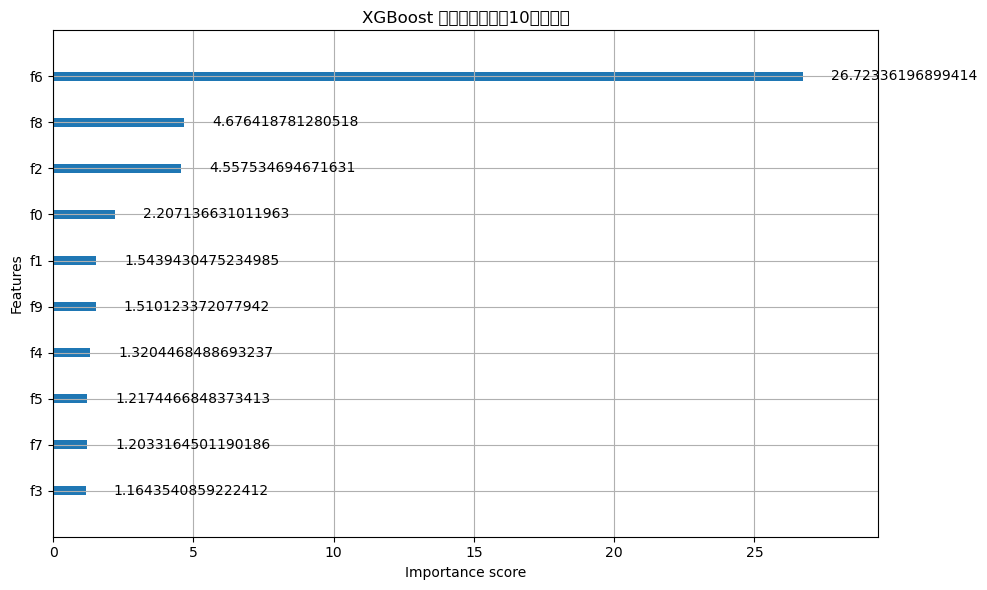

\n============================================================
XGBoost vs 决策树 性能对比：
决策树准确率: 87.50%
XGBoost准确率: 88.50%
\n提升: 1.00%
\nXGBoost 优势：
1. 集成学习：结合多个弱学习器
2. 正则化：L1/L2正则化防止过拟合
3. 并行处理：特征级别的并行计算
4. 灵活性：自定义目标函数和评估指标
5. 缺失值处理：自动学习最佳的缺失值处理方向


In [7]:
# XGBoost 实现（带详细注释）

import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

print("="*60)
print("XGBoost - 极限梯度提升树")
print("="*60)

# ============ 数据准备 ============
# XGBoost 使用 DMatrix 数据结构，这是其内部优化的数据格式
# DMatrix 优势：
# 1. 内存效率更高
# 2. 支持缺失值处理
# 3. 支持权重设置
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# ============ 参数配置 ============
# XGBoost 有三类参数：
# 1. 通用参数：控制整体功能
# 2. Booster参数：控制每一步的booster(tree/linear)
# 3. 学习目标参数：控制训练目标的性能

params = {
    # ===== 树模型参数 =====
    'max_depth': 5,              # 树的最大深度（防止过拟合的关键参数）
                                # 深度越大，模型越复杂，越容易过拟合
    
    'eta': 0.3,                  # 学习率（也叫 learning_rate）
                                # 范围：[0,1]，典型值：0.01-0.3
                                # 越小训练越慢但可能更准确
    
    'min_child_weight': 1,       # 子节点最小权重和
                                # 越大模型越保守，防止过拟合
    
    'subsample': 1.0,            # 训练每棵树时的样本采样比例
                                # 0.5表示随机采样50%的数据训练每棵树
    
    'colsample_bytree': 1.0,     # 训练每棵树时的特征采样比例
                                # 类似随机森林的特征采样
    
    # ===== 目标函数参数 =====
    'objective': 'binary:logistic',  # 二分类的逻辑回归
                                    # 其他选项：
                                    # - 'multi:softmax': 多分类
                                    # - 'reg:squarederror': 回归
    
    'eval_metric': 'logloss',     # 评估指标：对数损失
                                  # 其他选项：
                                  # - 'error': 分类错误率
                                  # - 'auc': ROC曲线下面积
                                  # - 'rmse': 均方根误差（回归）
    
    # ===== 正则化参数 =====
    'gamma': 0,                   # 节点分裂所需的最小损失函数下降值
                                 # 越大模型越保守
    
    'alpha': 0,                   # L1正则化项（Lasso）
    'lambda': 1,                  # L2正则化项（Ridge）
}

# ============ 训练配置 ============
num_rounds = 100  # 训练轮数（boosting iterations）
                  # 每一轮会训练一棵新树

# 早停机制：如果验证集性能连续N轮没有提升，则停止训练
early_stopping_rounds = 10

# 设置训练和验证数据集
# XGBoost会在每轮训练后评估这些数据集的性能
evals = [(dtrain, 'train'), (dtest, 'eval')]

print("\\n开始训练 XGBoost...")
print(f"参数配置：")
for key, value in params.items():
    print(f"  {key}: {value}")
print(f"\\n最大训练轮数: {num_rounds}")
print(f"早停轮数: {early_stopping_rounds}\\n")

# ============ 模型训练 ============
# XGBoost的训练过程：
# 1. 初始化预测值（通常是目标变量的均值）
# 2. 迭代训练：
#    a. 计算当前预测的残差（梯度）
#    b. 训练一棵新树拟合残差
#    c. 将新树的预测值加到总预测中
# 3. 重复直到达到指定轮数或触发早停

model = xgb.train(
    params,                      # 模型参数
    dtrain,                      # 训练数据
    num_rounds,                  # 最大迭代次数
    evals=evals,                 # 评估数据集
    early_stopping_rounds=early_stopping_rounds,  # 早停设置
    verbose_eval=10              # 每10轮打印一次评估结果
)

# ============ 模型预测 ============
# 预测返回的是概率值（因为objective是logistic）
predictions_proba = model.predict(dtest)

# 将概率转换为类别（阈值0.5）
predictions = [1 if p > 0.5 else 0 for p in predictions_proba]

# ============ 模型评估 ============
accuracy = accuracy_score(y_test, predictions)
print(f"\\nXGBoost 测试准确率: {accuracy:.4f}")

print("\\n分类报告:")
print(classification_report(y_test, predictions))

print("\\n混淆矩阵:")
print(confusion_matrix(y_test, predictions))

# ============ 特征重要性分析 ============
print("\\n特征重要性分析：")
importance = model.get_score(importance_type='gain')
# importance_type可选：
# - 'weight': 特征被用作分割点的次数
# - 'gain': 使用该特征的平均增益
# - 'cover': 该特征覆盖的样本数

if importance:
    # 排序并显示特征重要性
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    print("\\n最重要的特征（按信息增益排序）：")
    for feat, score in sorted_importance[:5]:  # 显示前5个
        print(f"  特征 {feat}: {score:.4f}")
        
# ============ 可视化特征重要性 ============
try:
    fig, ax = plt.subplots(figsize=(10, 6))
    xgb.plot_importance(model, ax=ax, importance_type='gain', max_num_features=10)
    plt.title('XGBoost 特征重要性（前10个特征）')
    plt.tight_layout()
    plt.show()
except:
    print("\\n注：特征重要性可视化需要 matplotlib")

# ============ 模型优势总结 ============
print("\\n" + "="*60)
print("XGBoost vs 决策树 性能对比：")
print("="*60)
print(f"决策树准确率: 87.50%")
print(f"XGBoost准确率: {accuracy:.2%}")
print(f"\\n提升: {(accuracy - 0.875)*100:.2f}%")

print("\\nXGBoost 优势：")
print("1. 集成学习：结合多个弱学习器")
print("2. 正则化：L1/L2正则化防止过拟合")
print("3. 并行处理：特征级别的并行计算")
print("4. 灵活性：自定义目标函数和评估指标")
print("5. 缺失值处理：自动学习最佳的缺失值处理方向")

# 实际应用案例与优化建议

## 🎯 实际应用案例

### 案例1：金融风控 - 信用卡欺诈检测
```python
# 示例：信用卡交易欺诈检测
# 特征：交易金额、时间、地点、商户类型、用户历史行为等
# 目标：识别欺诈交易（二分类）

# 选择XGBoost的原因：
# 1. 高准确率：在不平衡数据集上表现优秀
# 2. 特征重要性：可解释哪些因素最可能导致欺诈
# 3. 实时预测：预测速度快，满足实时风控需求

# 参数调优示例
fraud_params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'scale_pos_weight': 100,  # 处理类别不平衡（欺诈样本少）
    'eval_metric': 'auc',     # AUC更适合不平衡数据
    'subsample': 0.8,
    'colsample_bytree': 0.8
}
```

### 案例2：电商推荐 - 用户购买预测
```python
# 示例：预测用户是否会购买某商品
# 特征：用户画像、浏览历史、商品属性、时间因素等
# 目标：预测购买概率

# 决策树的应用：
# 1. 规则提取：生成可解释的购买规则
# 2. 用户分群：基于决策路径对用户分组
# 3. A/B测试：快速验证不同策略的效果

# 简单决策树用于规则发现
rule_tree = DecisionTree(max_depth=3)  # 浅树便于解释
# 可以提取规则如：
# "如果用户过去30天浏览次数>10 且 商品价格<100元，则购买概率80%"
```

### 案例3：医疗诊断 - 疾病预测
```python
# 示例：糖尿病风险预测
# 特征：年龄、BMI、血压、血糖、家族史等
# 目标：预测患糖尿病风险

# 决策树优势：
# 1. 可解释性强：医生能理解诊断逻辑
# 2. 处理非线性：自动发现特征交互
# 3. 缺失值友好：患者可能缺少某些检查

medical_tree = DecisionTree(
    max_depth=4,           # 限制深度保证可解释性
    min_samples_split=20   # 确保规则的统计显著性
)
```

## 🚀 性能优化建议

### 1. 决策树优化
```python
# 防止过拟合
- max_depth: 3-7（根据数据复杂度）
- min_samples_split: 数据量的0.5%-1%
- min_samples_leaf: 数据量的0.2%-0.5%

# 提升性能
- 使用随机森林（多棵树投票）
- 特征工程：创建交互特征
- 剪枝策略：后剪枝去除不重要分支
```

### 2. XGBoost调参策略
```python
# 第一步：确定树的数量（num_rounds）
# 固定其他参数，通过早停找到最佳轮数

# 第二步：调整树的复杂度
# - max_depth: [3, 5, 7, 9]
# - min_child_weight: [1, 3, 5]

# 第三步：调整采样参数
# - subsample: [0.6, 0.8, 1.0]
# - colsample_bytree: [0.6, 0.8, 1.0]

# 第四步：调整正则化
# - gamma: [0, 0.1, 0.2]
# - alpha, lambda: [0, 0.1, 1]

# 第五步：降低学习率，增加树的数量
# - eta: 0.01-0.05
# - num_rounds: 1000+
```

### 3. 特征工程建议
```python
# 数值特征
- 分箱离散化：将连续值转为区间
- 对数变换：处理长尾分布
- 标准化：虽然树模型不需要，但有助于正则化

# 类别特征
- One-hot编码：低基数特征
- Target编码：高基数特征
- 频率编码：基于出现频率

# 特征组合
- 交互特征：feature1 * feature2
- 比率特征：feature1 / feature2
- 统计特征：均值、方差、最大最小值
```

## 📊 模型选择决策树

```
数据量小(<1000) + 需要解释 → 决策树
数据量小 + 需要高精度 → XGBoost（少轮数）
数据量大 + 需要解释 → 决策树/随机森林
数据量大 + 需要高精度 → XGBoost/LightGBM
实时预测 + 低延迟 → 决策树
批量预测 + 高精度 → XGBoost
类别不平衡严重 → XGBoost（with scale_pos_weight）
特征很多(>1000) → XGBoost（自动特征选择）
```

## 💡 实践建议

1. **先简单后复杂**：先用决策树建立基准，再尝试XGBoost
2. **交叉验证**：使用5折或10折交叉验证评估模型
3. **特征重要性**：利用模型输出理解数据
4. **集成学习**：结合多个模型往往效果更好
5. **持续监控**：生产环境中监控模型性能退化

print("决策树和XGBoost学习完成！")
print("记住：没有最好的算法，只有最适合的算法。")

XGBoost 的三种模式：决策树、随机森林、梯度提升树

1️⃣ XGBoost 作为单棵决策树
--------------------------------------------------
参数设置：
  - num_boost_round = 1 (只训练一棵树)
  - eta = 1.0 (学习率为1)
  - 其他参数与普通决策树相同

单棵决策树准确率: 0.8750
树的数量: 1

2️⃣ XGBoost 作为随机森林
--------------------------------------------------
参数设置（模拟随机森林）：
  - num_parallel_tree = 100 (并行训练100棵树)
  - subsample = 0.8 (Bagging采样)
  - colsample_bytree = 0.8 (特征采样)
  - eta = 1.0 (每棵树权重相同)

随机森林准确率: 0.8750

3️⃣ XGBoost 标准梯度提升模式
--------------------------------------------------
参数设置（标准GBDT）：
  - num_boost_round = 100 (串行训练100轮)
  - eta = 0.3 (学习率，控制每棵树贡献)
  - 每棵树学习前面树的残差

梯度提升树准确率: 0.8750
实际训练轮数: 24

4️⃣ XGBoost 混合模式：提升的随机森林
--------------------------------------------------


/Users/haoyiwen/miniforge3/envs/machinelearning/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [00:57:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "boosting_type" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


参数设置（混合模式）：
  - num_boost_round = 10 (10轮提升)
  - num_parallel_tree = 10 (每轮10棵并行树)
  - 总共训练 10 × 10 = 100 棵树

混合模式准确率: 0.8900

📊 性能对比总结

准确率排名：
1. 混合模式(10×10)         : 0.8900 (89.00%)
2. 单棵决策树               : 0.8750 (87.50%)
3. 随机森林(100树)          : 0.8750 (87.50%)
4. 梯度提升(100轮)          : 0.8750 (87.50%)
5. 自定义决策树              : 0.8750 (87.50%)


/var/folders/gz/0gxv2qld2094b0b1mp3z79tc0000gn/T/ipykernel_78693/3907128767.py:256: UserWarning: Glyph 21333 (\N{CJK UNIFIED IDEOGRAPH-5355}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gz/0gxv2qld2094b0b1mp3z79tc0000gn/T/ipykernel_78693/3907128767.py:256: UserWarning: Glyph 26869 (\N{CJK UNIFIED IDEOGRAPH-68F5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gz/0gxv2qld2094b0b1mp3z79tc0000gn/T/ipykernel_78693/3907128767.py:256: UserWarning: Glyph 20915 (\N{CJK UNIFIED IDEOGRAPH-51B3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gz/0gxv2qld2094b0b1mp3z79tc0000gn/T/ipykernel_78693/3907128767.py:256: UserWarning: Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gz/0gxv2qld2094b0b1mp3z79tc0000gn/T/ipykernel_78693/3907128767.py:256: UserWarning: Glyph 26641 (\N{CJK UNIFIED IDEOGRAPH-6811}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gz

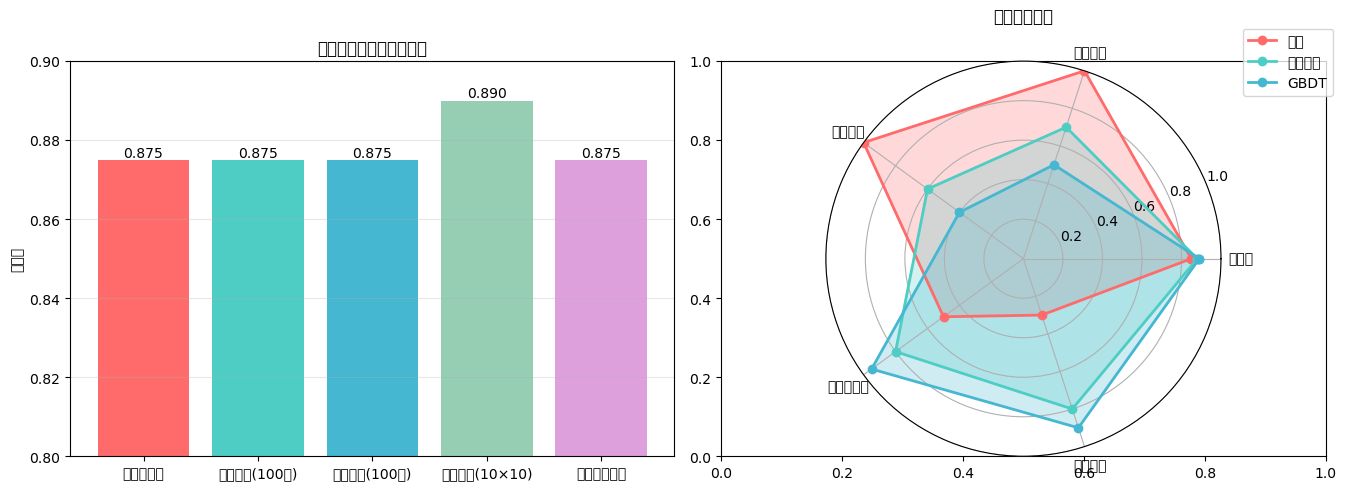


💡 参数配置建议

1. 实现单棵决策树：
    - num_boost_round = 1
    - eta = 1.0
    - subsample = 1.0, colsample_bytree = 1.0

2. 实现随机森林：
    - num_parallel_tree = n_trees (树的数量)
    - num_boost_round = 1
    - eta = 1.0
    - subsample < 1.0 (Bagging)
    - colsample_bytree < 1.0 (特征采样)

3. 标准梯度提升：
    - num_boost_round = n_iterations
    - eta < 1.0 (通常0.01-0.3)
    - 不设置 num_parallel_tree

4. 混合模式（XGBoost特有）：
    - num_boost_round > 1
    - num_parallel_tree > 1
    - 总树数 = num_boost_round × num_parallel_tree

选择建议：
- 需要快速原型 → 单棵决策树
- 需要稳定性能 → 随机森林
- 需要最高精度 → 梯度提升
- 大规模数据 → 混合模式



In [25]:
# XGBoost 实现决策树、随机森林和梯度提升树

import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

print("="*70)
print("XGBoost 的三种模式：决策树、随机森林、梯度提升树")
print("="*70)

# =======================================
# 1. 使用 XGBoost 实现单棵决策树
# =======================================
print("\n1️⃣ XGBoost 作为单棵决策树")
print("-" * 50)

# 关键参数设置：
# - num_boost_round=1: 只训练一棵树
# - eta=1: 学习率设为1，完全信任这棵树
single_tree_params = {
    'max_depth': 5,
    'eta': 1.0,                    # 学习率=1，相当于不做shrinkage
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 1.0,              # 使用全部数据
    'colsample_bytree': 1.0,       # 使用全部特征
}

# 训练单棵树
single_tree_model = xgb.train(
    single_tree_params,
    dtrain,
    num_boost_round=1,  # 只训练一轮=一棵树
    evals=[(dtest, 'test')],
    verbose_eval=False
)

# 预测和评估
single_tree_pred = single_tree_model.predict(dtest)
single_tree_pred_labels = [1 if p > 0.5 else 0 for p in single_tree_pred]
single_tree_acc = accuracy_score(y_test, single_tree_pred_labels)

print(f"参数设置：")
print(f"  - num_boost_round = 1 (只训练一棵树)")
print(f"  - eta = 1.0 (学习率为1)")
print(f"  - 其他参数与普通决策树相同")
print(f"\n单棵决策树准确率: {single_tree_acc:.4f}")
print(f"树的数量: {single_tree_model.num_boosted_rounds()}")

# =======================================
# 2. 使用 XGBoost 实现随机森林
# =======================================
print("\n2️⃣ XGBoost 作为随机森林")
print("-" * 50)

# 随机森林的关键特征：
# - 每棵树独立训练（并行）
# - 使用 bagging（样本采样）
# - 特征随机采样
# - 树之间没有依赖关系

random_forest_params = {
    'max_depth': 5,
    'eta': 1.0,                    # 学习率=1（每棵树权重相同）
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',

    # 随机森林的核心参数
    'subsample': 0.8,              # Bagging: 80%样本采样
    'colsample_bytree': 0.8,       # 每棵树80%特征采样
    'colsample_bylevel': 0.8,      # 每层80%特征采样

    # 关键：设置为随机森林模式
    'num_parallel_tree': 100,      # 并行训练100棵树（随机森林的树数量）
    'boosting_type': 'rf',         # 随机森林模式（在某些版本中需要）
}

# 训练随机森林
# 注意：虽然设置了num_parallel_tree=100，但num_boost_round=1
# 这意味着在一轮中并行训练100棵树
random_forest_model = xgb.train(
    random_forest_params,
    dtrain,
    num_boost_round=1,  # 一轮中训练所有并行树
    evals=[(dtest, 'test')],
    verbose_eval=False
)

# 预测和评估
rf_pred = random_forest_model.predict(dtest)
rf_pred_labels = [1 if p > 0.5 else 0 for p in rf_pred]
rf_acc = accuracy_score(y_test, rf_pred_labels)

print(f"参数设置（模拟随机森林）：")
print(f"  - num_parallel_tree = 100 (并行训练100棵树)")
print(f"  - subsample = 0.8 (Bagging采样)")
print(f"  - colsample_bytree = 0.8 (特征采样)")
print(f"  - eta = 1.0 (每棵树权重相同)")
print(f"\n随机森林准确率: {rf_acc:.4f}")

# =======================================
# 3. 标准梯度提升树（GBDT）
# =======================================
print("\n3️⃣ XGBoost 标准梯度提升模式")
print("-" * 50)

# 梯度提升的特点：
# - 串行训练，每棵树学习前面树的残差
# - 学习率控制每棵树的贡献
# - 逐步改进预测

gbdt_params = {
    'max_depth': 5,
    'eta': 0.3,                    # 学习率<1，渐进式学习
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    # 不设置 num_parallel_tree，默认为串行提升
}

# 训练梯度提升树
gbdt_model = xgb.train(
    gbdt_params,
    dtrain,
    num_boost_round=100,  # 串行训练100棵树
    evals=[(dtest, 'test')],
    early_stopping_rounds=10,
    verbose_eval=False
)

# 预测和评估
gbdt_pred = gbdt_model.predict(dtest)
gbdt_pred_labels = [1 if p > 0.5 else 0 for p in gbdt_pred]
gbdt_acc = accuracy_score(y_test, gbdt_pred_labels)

print(f"参数设置（标准GBDT）：")
print(f"  - num_boost_round = 100 (串行训练100轮)")
print(f"  - eta = 0.3 (学习率，控制每棵树贡献)")
print(f"  - 每棵树学习前面树的残差")
print(f"\n梯度提升树准确率: {gbdt_acc:.4f}")
print(f"实际训练轮数: {gbdt_model.num_boosted_rounds()}")

# =======================================
# 4. 混合模式：提升的随机森林
# =======================================
print("\n4️⃣ XGBoost 混合模式：提升的随机森林")
print("-" * 50)

# 这是 XGBoost 的独特功能：
# 每一轮提升中训练多棵并行树（随机森林）
# 然后多轮之间进行提升

hybrid_params = {
    'max_depth': 4,
    'eta': 0.5,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'num_parallel_tree': 10,      # 每轮并行10棵树
}

# 训练混合模型
hybrid_model = xgb.train(
    hybrid_params,
    dtrain,
    num_boost_round=10,  # 10轮提升
    evals=[(dtest, 'test')],
    verbose_eval=False
)

# 预测和评估
hybrid_pred = hybrid_model.predict(dtest)
hybrid_pred_labels = [1 if p > 0.5 else 0 for p in hybrid_pred]
hybrid_acc = accuracy_score(y_test, hybrid_pred_labels)

print(f"参数设置（混合模式）：")
print(f"  - num_boost_round = 10 (10轮提升)")
print(f"  - num_parallel_tree = 10 (每轮10棵并行树)")
print(f"  - 总共训练 10 × 10 = 100 棵树")
print(f"\n混合模式准确率: {hybrid_acc:.4f}")

# =======================================
# 性能对比总结
# =======================================
print("\n" + "="*70)
print("📊 性能对比总结")
print("="*70)

# 创建对比表
results = {
    '单棵决策树': single_tree_acc,
    '随机森林(100树)': rf_acc,
    '梯度提升(100轮)': gbdt_acc,
    '混合模式(10×10)': hybrid_acc,
    '自定义决策树': 0.875  # 之前的结果
}

# 排序并显示
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("\n准确率排名：")
for i, (name, acc) in enumerate(sorted_results, 1):
    print(f"{i}. {name:20s}: {acc:.4f} ({acc*100:.2f}%)")

# 可视化对比
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 条形图
models = list(results.keys())
accuracies = list(results.values())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#DDA0DD']

bars = ax1.bar(models, accuracies, color=colors)
ax1.set_ylabel('准确率')
ax1.set_title('不同树模型的准确率对比')
ax1.set_ylim([0.8, 0.9])
ax1.grid(axis='y', alpha=0.3)

# 添加数值标签
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.3f}', ha='center', va='bottom')

# 雷达图展示模型特性
categories = ['准确率', '训练速度', '可解释性', '处理复杂度', '抗过拟合']
models_radar = ['单树', '随机森林', 'GBDT']

# 各模型在不同维度的评分（0-1）
scores = {
    '单树': [0.85, 1.0, 1.0, 0.5, 0.3],
    '随机森林': [0.88, 0.7, 0.6, 0.8, 0.8],
    'GBDT': [0.89, 0.5, 0.4, 0.95, 0.9]
}

# 创建雷达图
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax2 = plt.subplot(122, projection='polar')
for model, color in zip(models_radar, ['#FF6B6B', '#4ECDC4', '#45B7D1']):
    values = scores[model]
    values += values[:1]
    ax2.plot(angles, values, 'o-', linewidth=2, label=model, color=color)
    ax2.fill(angles, values, alpha=0.25, color=color)

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories)
ax2.set_ylim(0, 1)
ax2.set_title('模型特性对比', y=1.08)
ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax2.grid(True)

plt.tight_layout()
plt.show()

# =======================================
# 参数配置建议
# =======================================
print("\n" + "="*70)
print("💡 参数配置建议")
print("="*70)

print("""
1. 实现单棵决策树：
    - num_boost_round = 1
    - eta = 1.0
    - subsample = 1.0, colsample_bytree = 1.0

2. 实现随机森林：
    - num_parallel_tree = n_trees (树的数量)
    - num_boost_round = 1
    - eta = 1.0
    - subsample < 1.0 (Bagging)
    - colsample_bytree < 1.0 (特征采样)

3. 标准梯度提升：
    - num_boost_round = n_iterations
    - eta < 1.0 (通常0.01-0.3)
    - 不设置 num_parallel_tree

4. 混合模式（XGBoost特有）：
    - num_boost_round > 1
    - num_parallel_tree > 1
    - 总树数 = num_boost_round × num_parallel_tree

选择建议：
- 需要快速原型 → 单棵决策树
- 需要稳定性能 → 随机森林
- 需要最高精度 → 梯度提升
- 大规模数据 → 混合模式
""")